[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](./README.md)

## Reinforcement learning example

This notebook shows a simple example of training an agent to optimize a reinforcement learning problem.
The OpenAI Gym is used, specifically the Taxi problem.
In this problem, a taxi living in a 5x5 grid must navigate to a passenger pickup location and then drop off the passenger at the desired destination.

Note that this notebook is written to demonstrate the different components.  It is not written for performance.

In [1]:
# Import libraries used
import gym

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# The hyperparameters
alpha = 0.2
gamma = 0.95
epsilon = 0.1

TRAIN_EPISODES = 700
DISPLAY_FREQ = 100
EVAL_EPISODES = 3

In [3]:
def Q_step(env, q_table, state):
    '''Pick one action and update value function based on reward received'''
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample() # Explore action space randomly
    else:
        action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

    next_state, reward, done, info = env.step(action) 

    old_value = q_table[state, action]
    next_max = np.max(q_table[next_state])

    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state, action] = new_value

    return next_state, reward, done


In [4]:
def count(q_table):
    '''Count the number of steps required to complete task using greedy policy'''
    curr_state = env.reset()
    counter = 0
    reward = None
    done = False
    while not done:
        state, reward, done, info = env.step(np.argmax(q_table[curr_state]))  
        curr_state = state
        counter += 1
    return counter

In [5]:
def penalties(q_table):
    '''Count the number of penalized actions (reward == -10) before complete task'''
    curr_state = env.reset()
    counter = 0
    reward = None
    done = False
    while not done:
        state, reward, done, info = env.step(np.argmax(q_table[curr_state]))  
        curr_state = state
        if reward == -10:
            counter += 1
    return counter

In [6]:
def display_count(q_table):
    '''Print the average number of steps and penalties to complete task'''
    counts = [count(q_table) for i in range(100)]
    pcount = [penalties(q_table) for i in range(100)]
    print("    Eval averages -- Time steps: {}, Penalties: {}".format(np.mean(counts),np.mean(pcount)))

In [7]:
from IPython.display import clear_output

def Q_learning_train(env, alpha, gamma, epsilon, episodes): 
    """Train agent using Q-learning algorithm with epsilon greedy actions

    Args:
        env:  the environment 
        alpha:  the learning rate
        gamma:  the discount rate for future rewards
        epsilon:  the probability of selecting a random action instead of the greedy action
        episodes:  the number of episodes to train

    Returns:
        Q table of estimated state values

    """
    # %%time
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    cum_epochs, cum_penalties, cum_rewards = 0, 0, 0
    for i in range(1, episodes+1):
        state = env.reset()

        epochs, penalties, total_reward, = 0, 0, 0
        done = False

        while not done:
            state, reward, done = Q_step(env, q_table, state)
            total_reward += reward

            if reward == -10:
                penalties += 1

            epochs += 1
            
        cum_epochs += epochs
        cum_penalties += penalties
        cum_rewards += total_reward
        if (i % DISPLAY_FREQ == 0):
            print("\nTraining episode {}".format(i))
            # print("Time steps: {}, Penalties: {}, Reward: {}".format(epochs, penalties, total_reward))
            print("Training averages -- Time steps: {}, Penalties: {}, Reward: {}".format(
                cum_epochs / DISPLAY_FREQ, cum_penalties / DISPLAY_FREQ, cum_rewards / DISPLAY_FREQ))
            cum_epochs, cum_penalties, cum_rewards = 0, 0, 0
            
            display_count(q_table)
        
    print("Training finished.\n")
    return q_table

In [8]:
def evaluate_agent(q_table, env, num_trials):
    ''''''
    total_epochs, total_penalties = 0, 0

    print("Running episodes...")
    for _ in range(num_trials):
        state = env.reset()
        epochs, num_penalties, reward = 0, 0, 0
        done = False

        while not done:
            next_action = np.argmax(q_table[state])
            if epochs < 50:
                print('Step', epochs, 'State', state)    # Agent can get stuck so stop displaying if it's taking too long
                env.render()
            state, reward, done, _ = env.step(next_action)

            if reward == -10:
                num_penalties += 1

            epochs += 1

        print('**********  DONE  **********')
        total_penalties += num_penalties
        total_epochs += epochs

    average_time = total_epochs / float(num_trials)
    average_penalties = total_penalties / float(num_trials)
    print("Evaluation results after {} trials".format(num_trials))
    print("Average time steps taken: {}".format(average_time))
    print("Average number of penalties incurred: {}".format(average_penalties))

In [9]:
random.seed(17)

In [10]:
# Create the reinforcement learning environment
env = gym.make('Taxi-v3')
env.reset()

# Initialize the Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
q_table = np.zeros([env.observation_space.n, env.action_space.n])  

In [11]:
# Train for a little while -- not fully trained
train_episodes = TRAIN_EPISODES

Q_table = Q_learning_train(env, alpha, gamma, epsilon, train_episodes)


Training episode 100
Training averages -- Time steps: 180.97, Penalties: 14.44, Reward: -304.84
    Eval averages -- Time steps: 200.0, Penalties: 11.8

Training episode 200
Training averages -- Time steps: 126.23, Penalties: 5.86, Reward: -163.22
    Eval averages -- Time steps: 198.06, Penalties: 29.8

Training episode 300
Training averages -- Time steps: 88.23, Penalties: 4.32, Reward: -107.58
    Eval averages -- Time steps: 180.86, Penalties: 1.99

Training episode 400
Training averages -- Time steps: 48.65, Penalties: 1.91, Reward: -44.84
    Eval averages -- Time steps: 169.56, Penalties: 6.0

Training episode 500
Training averages -- Time steps: 35.74, Penalties: 1.47, Reward: -28.18
    Eval averages -- Time steps: 144.94, Penalties: 7.99

Training episode 600
Training averages -- Time steps: 24.39, Penalties: 1.01, Reward: -12.48
    Eval averages -- Time steps: 124.41, Penalties: 7.96

Training episode 700
Training averages -- Time steps: 20.05, Penalties: 0.77, Reward: -5.

Current agent takes an average of about 87.288 steps to successfully complete the task.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


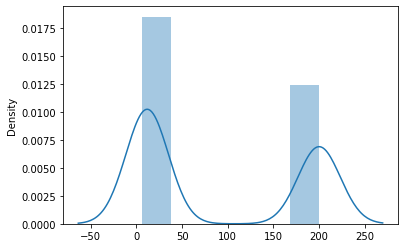

In [12]:
# Display histogram of number of steps
Q_counts = [count(Q_table) for i in range(1000)]
print("Current agent takes an average of about " + str(np.mean(Q_counts))
      + " steps to successfully complete the task.")
sns.distplot(Q_counts)

In [13]:
eval_episodes = EVAL_EPISODES

evaluate_agent(q_table, env, eval_episodes)

Running episodes...
Step 0 State 341
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Step 1 State 241
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 2 State 221
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Step 3 State 121
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 4 State 101
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Step 5 State 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 6 State 17
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Step 7 State 117
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Step 8 State 217
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (S

In [14]:
# Train some more.  Now the agent should be pretty good.
train_episodes = 4 * TRAIN_EPISODES

Q_table = Q_learning_train(env, alpha, gamma, epsilon, train_episodes)


Training episode 100
Training averages -- Time steps: 17.92, Penalties: 0.65, Reward: -2.77
    Eval averages -- Time steps: 79.57, Penalties: 2.0

Training episode 200
Training averages -- Time steps: 16.79, Penalties: 0.48, Reward: -0.11
    Eval averages -- Time steps: 61.43, Penalties: 1.99

Training episode 300
Training averages -- Time steps: 16.05, Penalties: 0.56, Reward: -0.09
    Eval averages -- Time steps: 47.81, Penalties: 0.0

Training episode 400
Training averages -- Time steps: 15.69, Penalties: 0.58, Reward: 0.09
    Eval averages -- Time steps: 40.89, Penalties: 0.0

Training episode 500
Training averages -- Time steps: 15.27, Penalties: 0.46, Reward: 1.59
    Eval averages -- Time steps: 35.08, Penalties: 0.0

Training episode 600
Training averages -- Time steps: 15.38, Penalties: 0.48, Reward: 1.3
    Eval averages -- Time steps: 22.23, Penalties: 0.0

Training episode 700
Training averages -- Time steps: 14.79, Penalties: 0.47, Reward: 1.98
    Eval averages -- Ti

Current agent takes an average of about 13.208 steps to successfully complete the task.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


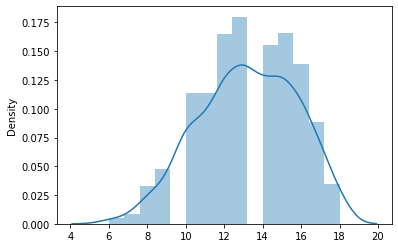

In [15]:
# Display histogram of number of steps
Q_counts = [count(Q_table) for i in range(1000)]
print("Current agent takes an average of about " + str(np.mean(Q_counts))
      + " steps to successfully complete the task.")
sns.distplot(Q_counts)

In [16]:
# Show the actions taken by agent trying to solve task
eval_episodes = EVAL_EPISODES

evaluate_agent(q_table, env, eval_episodes)

Running episodes...
Step 0 State 321
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Step 1 State 221
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 2 State 121
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 3 State 101
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Step 4 State 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Step 5 State 17
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Step 6 State 117
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Step 7 State 217
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Step 8 State 237
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (